In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")
df.head(10)
df.columns

Index(['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight',
       'acceleration', 'model_year', 'origin', 'fuel_type', 'drivetrain',
       'num_doors', 'fuel_efficiency_mpg'],
      dtype='object')

# Preparing the dataset

Use only the following columns:

'engine_displacement',
'horsepower',
'vehicle_weight',
'model_year',
'fuel_efficiency_mpg'

In [4]:
df_select = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]

# EDA
Look at the fuel_efficiency_mpg variable. Does it have a long tail?

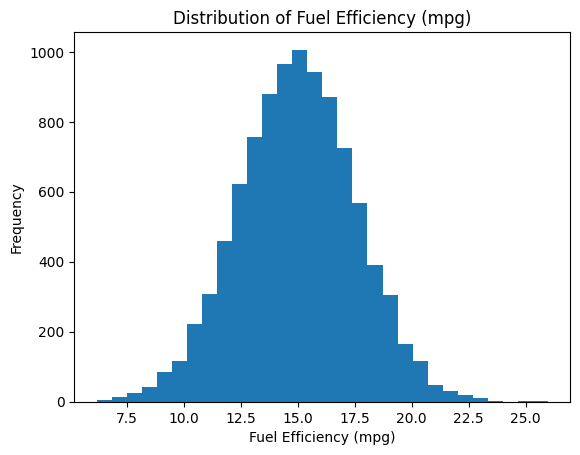

In [19]:
plt.hist(df_select['fuel_efficiency_mpg'], bins=30)
plt.xlabel('Fuel Efficiency (mpg)')
plt.ylabel('Frequency')
plt.title('Distribution of Fuel Efficiency (mpg)')
plt.show()

# Question 1

There's one column with missing values. What is it?

'engine_displacement'
'horsepower'
'vehicle_weight'
'model_year'

In [8]:
df_select.columns[df_select.isnull().any()]

Index(['horsepower'], dtype='object')

# Question 2

What's the median (50% percentile) for variable 'horsepower'?

49
99
149
199

In [9]:
df_select['horsepower'].median()

np.float64(149.0)

# Prepare and split the dataset

Shuffle the dataset (the filtered one you created above), use seed 42.
Split your data in train/val/test sets, with 60%/20%/20% distribution.
Use the same code as in the lectures

In [23]:
n = len(df_select)
idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

df_train = df_select.iloc[idx[:n_train]]
df_val = df_select.iloc[idx[n_train:n_train+n_val]]
df_test = df_select.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

# Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using round(score, 2)
* Which option gives better RMSE?

Options:

- With 0
- With mean
- Both are equally good

In [24]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [25]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [29]:
df_train_zero = df_train.copy()
df_train_mean = df_train.copy()
df_val_zero = df_val.copy()
df_val_mean = df_val.copy()

mean_value = df_train['horsepower'].mean()

df_train_zero['horsepower'] = df_train_zero['horsepower'].fillna(0)
df_train_mean['horsepower'] = df_train_mean['horsepower'].fillna(mean_value)
df_val_zero['horsepower'] = df_val_zero['horsepower'].fillna(0)
df_val_mean['horsepower'] = df_val_mean['horsepower'].fillna(mean_value)

In [30]:
w0, w = train_linear_regression(df_train_zero, y_train)

y_pred = w0 + df_val_zero.dot(w)
rmse(y_val, y_pred)

np.float64(0.5173782638844466)

In [31]:
w0, w = train_linear_regression(df_train_mean, y_train)

y_pred = w0 + df_val_mean.dot(w)
rmse(y_val, y_pred)

np.float64(0.4635965042334585)

# Question 4

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

If multiple options give the same best RMSE, select the smallest r.

Options:

- 0
- 0.01
- 1
- 10
- 100

In [32]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [34]:
for r in [0.0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_linear_regression_reg(df_train_zero, y_train, r=r)

    y_pred = w0 + df_val_zero.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, score)

0.0 28.82736547365895 0.5173782638844466
0.01 24.92683841981215 0.5171115525769823
0.1 11.239661084581073 0.5187525130702517
1 1.7315979411219746 0.5222348802093141
5 0.3638075020482907 0.522891609282361
10 0.18306246621686947 0.5229812979636599
100 0.01841801730688404 0.5230636233819933


answer: r = 0.01

# Question 5

* We used seed 42 for splitting the data.
* Let's find out how selecting the seed influences our score.
* Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
* Round the result to 3 decimal digits (round(std, 3))

What's the value of std?

- 0.001
- 0.006
- 0.060
- 0.600

In [39]:
all_scores = []
for s in [0,1,2,3,4,5,6,7,8,9]:
    n = len(df_select)
    idx = np.arange(n)

    np.random.seed(s)
    np.random.shuffle(idx)

    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    df_train = df_select.iloc[idx[:n_train]]
    df_val = df_select.iloc[idx[n_train:n_train+n_val]]
    df_test = df_select.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test = df_test.fuel_efficiency_mpg.values

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']
    
    df_train_zero = df_train.copy()
    df_val_zero = df_val.copy()

    df_train_zero['horsepower'] = df_train_zero['horsepower'].fillna(0)
    df_val_zero['horsepower'] = df_val_zero['horsepower'].fillna(0)

    w0, w = train_linear_regression(df_train_zero, y_train)

    y_pred = w0 + df_val_zero.dot(w)
    score = rmse(y_val, y_pred)
    all_scores.append(score)
    print(s, w0, score)
print(all_scores)
print(np.std(all_scores))
round(np.std(all_scores),3)

0 27.376388746528697 0.5206531296294218
1 29.02246855416138 0.521338891285577
2 25.904357611049043 0.5228069974803171
3 28.015450067910564 0.515951674119676
4 25.93400040472635 0.5109129460053851
5 25.89950696063403 0.52834064601107
6 25.917230934138303 0.5313910658146311
7 28.414324731275375 0.5090670387381733
8 26.47841782687521 0.5147399129511132
9 27.513852581224892 0.5131865908224594
[np.float64(0.5206531296294218), np.float64(0.521338891285577), np.float64(0.5228069974803171), np.float64(0.515951674119676), np.float64(0.5109129460053851), np.float64(0.52834064601107), np.float64(0.5313910658146311), np.float64(0.5090670387381733), np.float64(0.5147399129511132), np.float64(0.5131865908224594)]
0.006989446426433706


np.float64(0.007)

# Question 6

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

Options:

- 0.15
- 0.515
- 5.15
- 51.5

In [41]:
n = len(df_select)
idx = np.arange(n)

np.random.seed(9)
np.random.shuffle(idx)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

df_train = df_select.iloc[idx[:n_train]]
df_val = df_select.iloc[idx[n_train:n_train+n_val]]
df_test = df_select.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']
    
df_train_zero = df_train.copy()
df_val_zero = df_val.copy()
df_test_zero = df_test.copy()

df_train_zero['horsepower'] = df_train_zero['horsepower'].fillna(0)
df_val_zero['horsepower'] = df_val_zero['horsepower'].fillna(0)
df_test_zero['horsepower'] = df_test_zero['horsepower'].fillna(0)

df_full_train = pd.concat([df_train_zero, df_val_zero])
df_full_train = df_full_train.reset_index(drop=True)

y_full_train = np.concatenate([y_train, y_val])

              
w0, w = train_linear_regression_reg(df_full_train, y_full_train, r=0.001)

y_pred = w0 + df_test.dot(w)
score = rmse(y_test, y_pred)
score

np.float64(0.4982088125067631)